In [1]:
import numpy as np
import healpy as hp
import pysm3.units as u


In [2]:
from cmbml.utils.fits_inspection import get_field_unit

from cmbml.utils.handle_data import (
    get_planck_obs_data, 
    get_planck_noise_data, 
    # get_planck_hm_data, 
    get_map_dtype
    )
from system_config import ASSETS_DIRECTORY, PLANCK_NOISE_DIRECTORY

In [3]:
data_fn = "noise_model_details/noise_model_detail_100GHz.npz"
data = np.load(data_fn)

In [4]:
data["src_cls"].shape

(100, 6144)

In [5]:
src_cls = data["src_cls"]
mu_ell = np.mean(src_cls, axis=0)      # shape (6144,)
var_ell = np.var(src_cls, axis=0, ddof=1)  # unbiased, shape (6144,)

# Make a hallucinated spectrum

## Utils

copied from demo_noise_method_100

In [6]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

In [7]:
def get_target_cls_from_pca_results(n_sims, src_mean_ps, src_variance, src_components):
    num_components = len(src_variance)

    std_devs = np.sqrt(src_variance)

    if n_sims == 1:
        reduced_shape = (num_components,)
    else:
        reduced_shape = (n_sims, num_components)

    reduced_samples = np.random.normal(0, std_devs, reduced_shape)
    # Reconstruct power spectra in log10 space
    tgt_log_ps = reduced_samples @ src_components + src_mean_ps
    # Convert out of log10 space
    tgt_cls = 10**tgt_log_ps
    return tgt_cls

In [8]:
def convert_field_str_to_Unit(unit_str):
    custom_units = {
            # 'uK_CMB': u.uK_CMB,
            'Kcmb': u.K_CMB,
            # 'K_CMB': u.K_CMB,
            'MJy/sr': u.MJy / u.sr,
            'Kcmb^2': u.K_CMB**2,
            '(K_CMB)^2': u.K_CMB**2,
            # 'K_CMB^2': u.K_CMB**2,
            # 'uK_CMB^2': u.uK_CMB**2,
            # '(uK_CMB)^2': u.uK_CMB**2,
            # '(MJy/sr)^2': (u.MJy / u.sr)**2,
            '(Mjy/sr)^2': (u.MJy / u.sr)**2,
            # 'MJy/sr^2': (u.MJy / u.sr)**2
        }
    if not isinstance(unit_str, str):
        try:
            unit_str = unit_str.item()
        except AttributeError:
            raise TypeError(f"Expected a string, but got {type(unit_str)}")

    try:
        # Attempt to parse with Astropy's Unit function
        return u.Unit(unit_str)
    except ValueError:  # Astropy throws a ValueError for unrecognized units
        if unit_str in custom_units.keys():
            return custom_units[unit_str]
        else:
            raise ValueError(f"Unit {unit_str} not recognized.")

In [9]:
def make_tgt_noise_params_from_det_file(det, n_sims=1):
    data = np.load(f"noise_models2/noise_model_{det}GHz.npz")

    src_mean_ps     = data['mean_ps']
    src_components  = data['components']
    src_variance    = data['variance']

    # src_mean_maps   = data['maps_mean']
    # src_sd_maps     = data['maps_sd']

    src_map_unit    = data['maps_unit'].item()

    src_map_unit = convert_field_str_to_Unit(src_map_unit)

    tgt_cls = get_target_cls_from_pca_results(n_sims, src_mean_ps, src_variance, src_components)

    return tgt_cls, src_map_unit

In [10]:
def get_xxcov_field_num(detector, field_str):
    if detector not in [30, 44, 70, 100, 143, 217, 353, 545, 857]:
        raise ValueError(f"Detector {detector} not recognized")
    field_str = field_str.lower()
    lower_field_nums = dict(ii=4, iq=5, iu=6, qq=7, qu=8, uu=9)
    upper_field_nums = dict(ii=2)  # These detectors only have intensity data
    if detector in [545, 857]:
        if field_str not in upper_field_nums.keys():
            raise ValueError(f"Field {field_str} not available for detector {detector}")
        res = upper_field_nums[field_str]
    else:
        if field_str not in ['ii', 'iq', 'iu', 'qq', 'qu', 'uu']:
            raise ValueError(f"Field {field_str} not available for detector {detector}")
        res = lower_field_nums[field_str]
    return res

## Params

In [13]:
WHT_SEED = 42
NSIDE_OUTPUT  = 512
DETECTOR      = 100
WHT_SEED      = 42   # seed for the white noise sims

In [26]:
_tgt_cls, _src_map_unit = make_tgt_noise_params_from_det_file(DETECTOR, 100)

In [27]:
_tgt_cls.shape

(100, 6144)

In [28]:
mu_ell.shape, var_ell.shape, _tgt_cls.shape

((6144,), (6144,), (100, 6144))

In [29]:
chi2_values = ((_tgt_cls - mu_ell)**2) / var_ell  # shape (M, 6144)

In [30]:
chi2_values.shape

(100, 6144)

In [31]:
from scipy.stats import chi2, kstest

# Sum over ell for each hallucinated sample
chi2_total = np.sum(chi2_values, axis=1)  # shape (M,)
dof = chi2_values.shape[1]

# Compare against chi2 distribution with `dof` degrees of freedom
ks_stat, p_value = kstest(chi2_total, chi2(dof).cdf)
print(f"KS statistic: {ks_stat}, p-value: {p_value}")

KS statistic: 0.43331283011877864, p-value: 1.383745193978894e-17


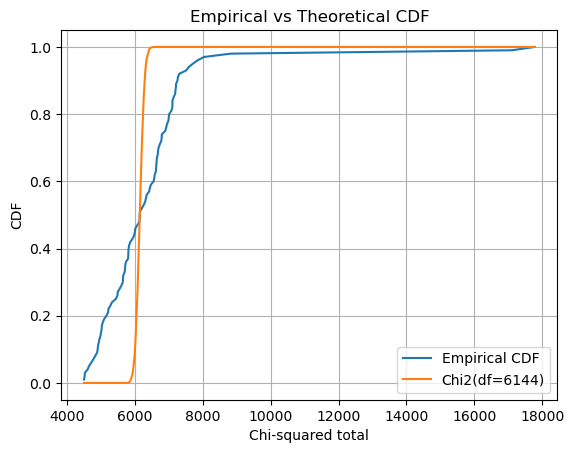

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import chi2

chi2_total_sorted = np.sort(chi2_total)
empirical_cdf = np.arange(1, len(chi2_total_sorted) + 1) / len(chi2_total_sorted)
theoretical_cdf = chi2.cdf(chi2_total_sorted, df=dof)

plt.plot(chi2_total_sorted, empirical_cdf, label='Empirical CDF')
plt.plot(chi2_total_sorted, theoretical_cdf, label=f'Chi2(df={dof})')
plt.xlabel("Chi-squared total")
plt.ylabel("CDF")
plt.legend()
plt.title("Empirical vs Theoretical CDF")
plt.grid(True)
plt.show()


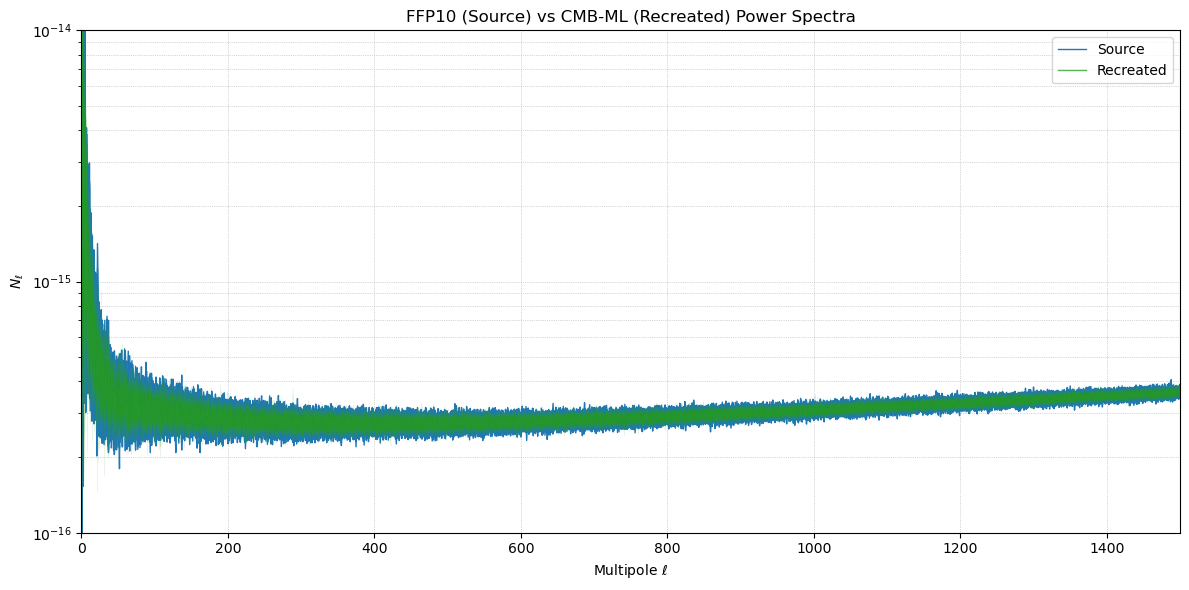

In [86]:
import numpy as np
import matplotlib.pyplot as plt

N = src_cls.shape[0]

plt.figure(figsize=(12, 6))

for i in range(N):
    plt.plot(src_cls[i], color='tab:blue', alpha=1, linewidth=1, label='Source' if i == 0 else "")
for i in range(N):
    plt.plot(_tgt_cls[i], color='tab:green', alpha=0.8, linewidth=0.05, label='')

plt.plot([1000,1001], color='tab:green', alpha=0.8, linewidth=1, label='Recreated')

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$N_\ell$')
plt.title("FFP10 (Source) vs CMB-ML (Recreated) Power Spectra")
plt.yscale('log')
plt.ylim(1e-16, 1e-14)
plt.xlim(0, 1500)

plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.savefig("ffp10_vs_cmbml.pdf", dpi=300)
plt.show()

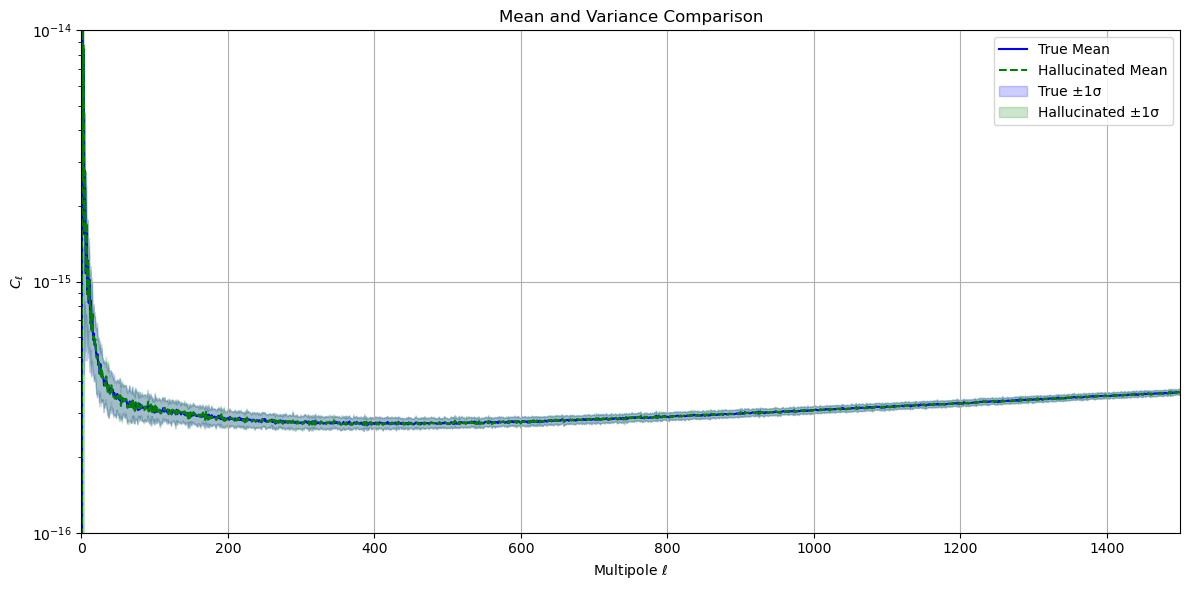

In [85]:
import matplotlib.pyplot as plt

mean_true = src_cls.mean(axis=0)
std_true = src_cls.std(axis=0)

mean_fake = _tgt_cls.mean(axis=0)
std_fake = _tgt_cls.std(axis=0)

plt.figure(figsize=(12, 6))
plt.plot(mean_true, label="True Mean", color="blue")
plt.plot(mean_fake, label="Hallucinated Mean", color="green", linestyle="--")
plt.fill_between(
    np.arange(len(mean_true)),
    mean_true - std_true,
    mean_true + std_true,
    color="blue",
    alpha=0.2,
    label="True ±1σ"
)
plt.fill_between(
    np.arange(len(mean_fake)),
    mean_fake - std_fake,
    mean_fake + std_fake,
    color="green",
    alpha=0.2,
    label="Hallucinated ±1σ"
)
plt.yscale('log')
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$C_\ell$")
plt.ylim(1e-16, 1e-14)
plt.xlim(0, 1500)
plt.title("Mean and Variance Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("mean_variance_comparison.pdf", dpi=300)
plt.show()

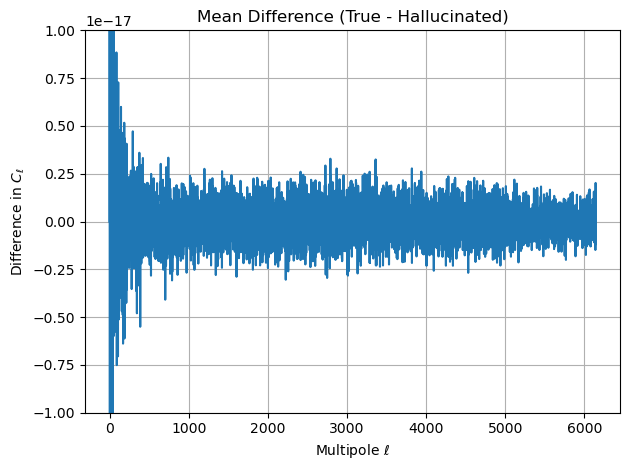

In [47]:
plt.plot(mean_true - mean_fake)
plt.title("Mean Difference (True - Hallucinated)")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"Difference in $C_\ell$")
plt.ylim(-1e-17, 1e-17)  # Adjust the y-axis limits as needed
plt.grid(True)
plt.tight_layout()
plt.show()


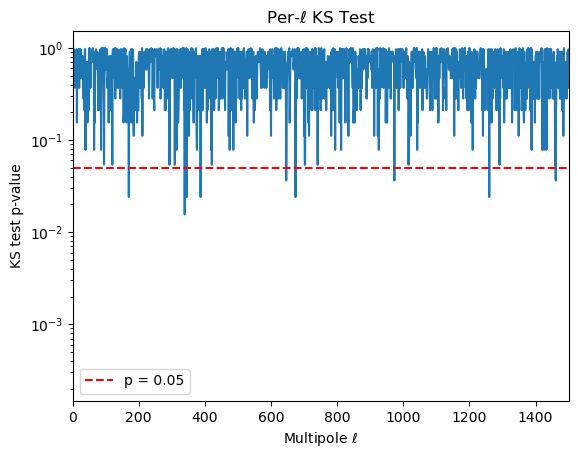

In [84]:
from scipy.stats import ks_2samp

p_values = []
for ell in range(src_cls.shape[1]):
    stat, p = ks_2samp(src_cls[:, ell], _tgt_cls[:, ell])
    p_values.append(p)

# Visualize where mismatches happen
import matplotlib.pyplot as plt
plt.plot(p_values)
plt.yscale('log')
plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
plt.xlabel(r'Multipole $\ell$')
plt.xlim(0, 1500)
plt.ylabel("KS test p-value")
plt.title("Per-$\ell$ KS Test")
plt.legend()
plt.savefig("per_ell_ks_test.pdf", dpi=300)
plt.show()

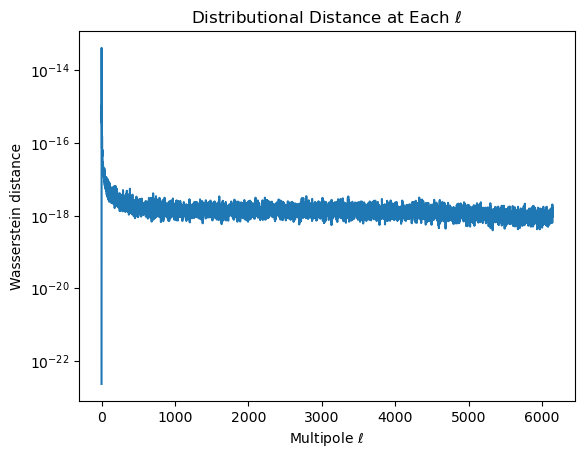

In [83]:
from scipy.stats import wasserstein_distance

w_dists = [wasserstein_distance(src_cls[:, ell], _tgt_cls[:, ell]) for ell in range(src_cls.shape[1])]
plt.plot(w_dists)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel("Wasserstein distance")
plt.yscale('log')
plt.title("Distributional Distance at Each $\ell$")
plt.savefig("wasserstein_distance.pdf", dpi=300)
plt.show()